In [1]:
import sys
print(sys.executable)

%load_ext autoreload
%autoreload 2

/Users/BERL/Github/venv_sksparse/bin/python3.11


In [2]:
import numpy as np
import scipy as sp
import networkx as nx
from gstools import SRF, Exponential
from gstools.random import MasterRNG
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets
import plotly.graph_objects as go
from tqdm import tqdm

from graphite_maps.enif import EnIF
from iterative_ensemble_smoother.experimental import AdaptiveESMDA

In [3]:
def plot_field(i, title):
    plt.figure(figsize=(5, 5))
    # Find global min and max across all fields to set color scale
    vmin = np.min([np.min(u) for u in field])
    vmax = np.max([np.max(u) for u in field])
    plt.imshow(field[i], cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f"{title} {i}")
    plt.colorbar()
    plt.show

def create_flattened_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to the right neighbor
            if j < py - 1:
                G.add_edge(index, index + 1)
            # Connect to the bottom neighbor
            if i < px - 1:
                G.add_edge(index, index + py)
    return G

def draw_2d_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, node // dim_y) for node in G.nodes()}
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=node_size)
    plt.show()

def create_triangular_grid_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to the right neighbor
            if j < py - 1:
                G.add_edge(index, index + 1)
            # Connect to the bottom neighbor
            if i < px - 1:
                G.add_edge(index, index + py)
            # Connect diagonally to the bottom-right neighbor
            if i < px - 1 and j < py - 1:
                G.add_edge(index, index + py + 1)
    return G

def create_extended_connectivity_grid_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to right and bottom neighbors (primary connections)
            if j < py - 1:
                G.add_edge(index, index + 1)
            if i < px - 1:
                G.add_edge(index, index + py)
            # Connect diagonally to the bottom-right neighbor (creates triangles)
            if i < px - 1 and j < py - 1:
                G.add_edge(index, index + py + 1)
    
   

    return G

def draw_2d_extended_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, -node // dim_y) for node in G.nodes()}  # Negative y for correct orientation
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', edge_color='gray')
    plt.gca().invert_yaxis()  # Invert y-axis to display the graph in matrix coordinate style
    plt.title("Extended Connectivity Grid Graph")
    plt.show()

def draw_2d_triangular_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, -node // dim_y) for node in G.nodes()}  # Negative y for correct orientation
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', edge_color='gray')
    plt.gca().invert_yaxis()  # Invert y-axis to display the graph in matrix coordinate style
    plt.title("Triangular Grid Graph")
    plt.show()

def plot_field_from_vector(U_i, px, py, vmin, vmax, title="2D Field"):
    """
    Plots a 2D field from a flattened realization.

    Parameters:
    - U_i: A flattened 2D field (1D numpy array).
    - px: The x-dimension (width) of the original 2D field.
    - py: The y-dimension (height) of the original 2D field.
    - title: Title of the plot.
    """
    # Reshape U_i into its original 2D form
    field_2d = U_i.reshape((px, py))
    
    # Create the plot
    plt.figure(figsize=(6, 5))
    plt.imshow(field_2d, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('X dimension')
    plt.ylabel('Y dimension')
    plt.show()

def plot_field_3d(U_i, px, py, vmin, vmax, title="3D Field", azim=30, file_name=None):
    """
    Plots a 3D field from a flattened realization.

    Parameters:
    - U_i: A flattened 2D field (1D numpy array).
    - px: The x-dimension (width) of the original 2D field.
    - py: The y-dimension (height) of the original 2D field.
    - vmin: Minimum value for colormap and z-axis.
    - vmax: Maximum value for colormap and z-axis.
    - title: Title of the plot.
    """
    # Reshape U_i into its original 2D form
    field_2d = U_i.reshape((px, py))
    
    # Create meshgrid for x and y dimensions
    x = np.linspace(0, px-1, px)
    y = np.linspace(0, py-1, py)
    X, Y = np.meshgrid(x, y)
    
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, field_2d.T, cmap='viridis', edgecolor='none', vmin=vmin, vmax=vmax)
    
    # Add a color bar
    #fig.colorbar(surf, shrink=0.5, aspect=5, label='Value')
    
    ax.set_title(title)
    ax.set_xlabel('X dimension')
    ax.set_ylabel('Y dimension')
    ax.set_zlabel('Values')
    ax.set_zlim(vmin, vmax)

    # Set the view angle
    ax.view_init(azim=azim)

    if file_name is not None:
        plt.savefig(f"{file_name}.png", dpi=300)

    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_fields_3d(U_is, px, py, vmin, vmax, titles, azim=30, overall_title="Overall 3D Fields", file_name=None):
    """
    Plots 3D fields from flattened realizations side-by-side with an overall title.

    Parameters:
    - U_is: List of flattened 2D fields (1D numpy arrays).
    - px: The x-dimension (width) of the original 2D fields.
    - py: The y-dimension (height) of the original 2D fields.
    - vmin: Minimum value for colormap and z-axis.
    - vmax: Maximum value for colormap and z-axis.
    - titles: List of titles for each subplot.
    - overall_title: The overall title for the figure.
    - azim: Azimuthal angle for the 3D plot.
    - file_name: Filename to save the figure.
    """
    fig = plt.figure(figsize=(24, 6))  # Adjust the figure size as needed
    fig.suptitle(overall_title, fontsize=16)  # Set the overall title

    axes = []  # List to store axes for color bar adjustment
    for i, (U_i, title) in enumerate(zip(U_is, titles), start=1):
        field_2d = U_i.reshape((px, py))
        x = np.linspace(0, px-1, px)
        y = np.linspace(0, py-1, py)
        X, Y = np.meshgrid(x, y)
        
        ax = fig.add_subplot(1, 4, i, projection='3d')  # Adjust for four subplots
        axes.append(ax)
        surf = ax.plot_surface(X, Y, field_2d.T, cmap='viridis', edgecolor='none', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel('X dimension')
        ax.set_ylabel('Y dimension')
        ax.set_zlabel('Values')
        ax.set_zlim(vmin, vmax)
        ax.view_init(azim=azim)
    
    # Adjust the color bar to be shared across all subplots
    #fig.subplots_adjust(right=0.85)  # Adjust subplot spacing to fit color bar
    #cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Position for color bar
    #fig.colorbar(surf, cax=cbar_ax, label='Value')

    # Save the plot if a filename is specified
    #if file_name is not None:
    #    plt.savefig(f"{file_name}.png", dpi=300)  # Save figure with high dpi for better resolution
    if file_name is not None:
        plt.savefig(f"{file_name}.pdf", format='pdf', bbox_inches='tight')


    plt.show()

In [37]:
px, py = 50, 50
p = px * py
n = 100

# Anisotropic exponential covariance Gaussian field

- variance $\sigma^2=1$
- correlation length $\lambda = (12,3)^T$
- rotation angle $\phi = \pi/8$

see [GSTools tutorial](https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_01_srf.html#creating-fancier-fields)

In [38]:
model = Exponential(dim=2, var=1, len_scale=[.12 * px, .03 * px], angles=np.pi/8)
srf = SRF(model)
seed = MasterRNG(20170519)

field = []
x, y = np.arange(px), np.arange(py)
for i in tqdm(range(n), desc="Simulating fields"):
    field.append(srf.structured([x,y], seed=seed()))

Simulating fields: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.91it/s]


In [39]:
# If data is pre-generated
import pickle
if False:
    with open('field_1000x1000.pkl', 'wb') as file:
        pickle.dump(field, file)
if False:
    with open('field_1000x1000.pkl', 'rb') as file:
        field = pickle.load(file)

In [40]:
vmin = np.min([np.min(u) for u in field])
vmax = np.max([np.max(u) for u in field])

ipywidgets.interact(
    plot_field,
    i=ipywidgets.IntSlider(min=0, max=n - 1, step=1, value=0),
    title = "Prior parameter field",
)
plt.show()

interactive(children=(IntSlider(value=0, description='i', max=99), Text(value='Prior parameter field', descrip…

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

def create_selective_connectivity_grid_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to right and bottom neighbors (primary connections)
            if j < py - 1:
                G.add_edge(index, index + 1)
            if i < px - 1:
                G.add_edge(index, index + py)
            # Connect diagonally to the bottom-right neighbor (creates triangles)
            if i < px - 1 and j < py - 1:
                G.add_edge(index, index + py + 1)
    
    # Add selective connections to neighbors of neighbors
    for index in range(px * py):
        first_order_neighbors = list(G.neighbors(index))
        added_neighbors = set(first_order_neighbors)  # Keep track of already directly connected nodes

        for neighbor in first_order_neighbors:
            second_order_neighbors = list(G.neighbors(neighbor))
            for second_neighbor in second_order_neighbors:
                if second_neighbor != index and second_neighbor not in added_neighbors:
                    G.add_edge(index, second_neighbor)
                    added_neighbors.add(second_neighbor)

    return G

def draw_2d_selective_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, -node // dim_y) for node in G.nodes()}  # Adjust node positions
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', edge_color='gray')
    plt.gca().invert_yaxis()  # Invert y-axis for proper orientation
    plt.title("Selective Connectivity Grid Graph")
    plt.show()


In [42]:
# Create the graph for the flattened field with separate dimensions
Graph_u = create_flattened_graph(px, py)
print(Graph_u)
#Graph_u.edges(101)  

Graph with 2500 nodes and 4900 edges


In [43]:
G = Graph_u.copy()  # Work with a copy to preserve the original graph during modifications

# Add selective connections to neighbors of neighbors (up to third order)
for index in range(px * py):
    first_order_neighbors = list(Graph_u.neighbors(index))
    all_connected_neighbors = set(first_order_neighbors)  # Track all directly connected nodes#

    for neighbor in first_order_neighbors:
        second_order_neighbors = list(Graph_u.neighbors(neighbor))
        for second_neighbor in second_order_neighbors:
            if second_neighbor != index and second_neighbor not in all_connected_neighbors:
                G.add_edge(index, second_neighbor)
                all_connected_neighbors.add(second_neighbor)
#            # Move to third-order neighbors
#            third_order_neighbors = list(Graph_u.neighbors(second_neighbor))
#            for third_neighbor in third_order_neighbors:
#                if third_neighbor != index and third_neighbor not in all_connected_neighbors:
#                    G.add_edge(index, third_neighbor)
#                    all_connected_neighbors.add(third_neighbor)#

Graph_u2 = G  # Replace the original graph with the modified version if needed

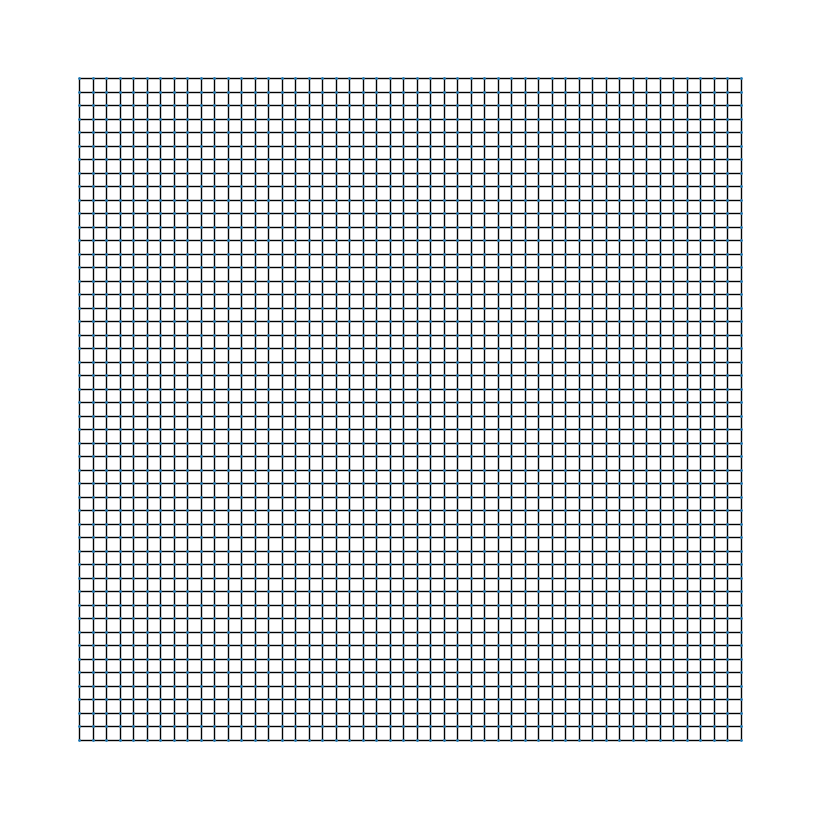

In [44]:
# Visualize the graph -- knowing 2-d structure
draw_2d_grid_graph(Graph_u, px, py, node_size=1)

In [45]:
U = np.zeros((n,p))
for i in range(n):
    U[i,:] = field[i].flatten()

# Compute responses

In [46]:
def h(U_i, j, a=1.0, b=5):
    return a * U_i[j] + b

In [47]:
m = min(px, py)  # Number of elements on the diagonal
Y = np.zeros((n, m))
a, b = 1.0, 5
for i in range(n):
    U_i = U[i, :]
    for k in range(m):
        j = k * (py + 1)  # Index for the diagonal element in the vectorized field
        Y[i, k] = h(U_i, j, a, b) + 0.1 * np.random.normal()

# Create observations -- we observe the diagonal in the 2D-field

In [48]:
d = np.repeat(8.0, m)

# Be specific about precision of noise
var_eps = 1.0
Prec_eps = sp.sparse.diags(
    [np.repeat(1/var_eps, m)], 
    offsets=[0],
    shape=(m, m), 
    format='csc'
)

## Ensemble Smoother

In [49]:
def ES(U, Y, d, Cov_epsilon):
    # Cross-covariance matrix C_UY has shape (p, m)
    n, m = Y.shape
    C_UY = np.dot((U - U.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)
    print(C_UY.shape)

    # Compute the covariance of Y
    # Covariance matrix C_YY has shape (m, m)
    C_YY = np.dot((Y - Y.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)

    print(C_YY.shape)

    # Estimated K
    K = C_UY @ np.linalg.inv(C_YY + Cov_epsilon)
    print(K.shape)
    
    # perturb observations
    n, m = Y.shape
    eps = np.random.normal(loc=0, scale=np.sqrt(Cov_epsilon.diagonal()), size=(n,m))
    di = d - eps

    U_posterior = np.copy(U)
    for i in range(n):
        U_posterior[i,:] += K @ (di[i] - Y[i,:])
    
    return U_posterior

In [50]:
U_posterior_es = ES(U, Y, d, np.linalg.inv(Prec_eps.A))

(2500, 50)
(50, 50)
(2500, 50)


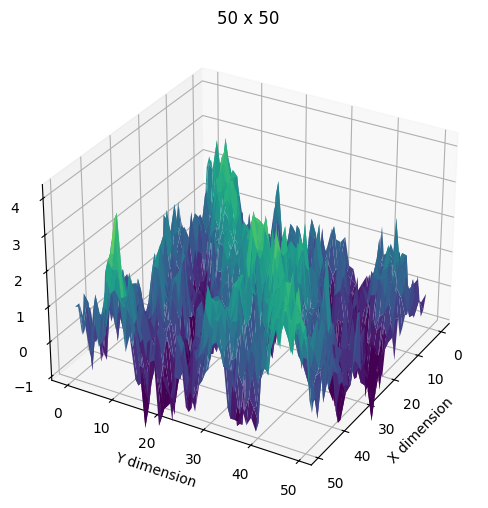

In [51]:
plot_field_3d(
    np.mean(U_posterior_es-U, axis=0),
    px, py, 
    vmin=-1, vmax=vmax,
    title = f"{px} x {py}",
    file_name=f"field_update_es_px{px}py{py}n{n}"
)

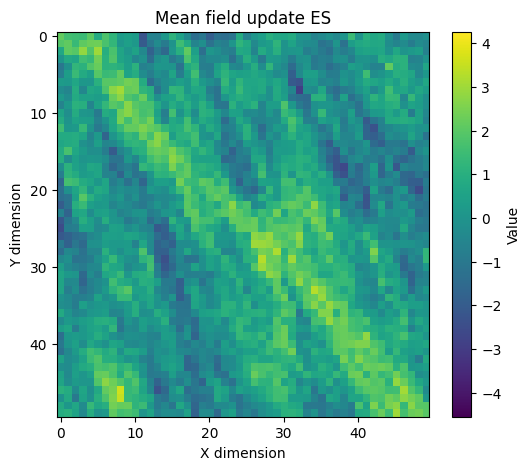

In [52]:
plot_field_from_vector(np.mean(U_posterior_es-U, axis=0), px, py, vmin, vmax, title="Mean field update ES")

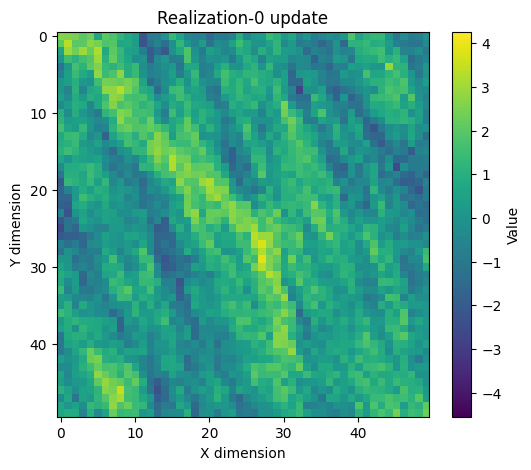

In [53]:
plot_field_from_vector(U_posterior_es[0,:]-U[0,:], px, py, vmin, vmax, title="Realization-0 update")

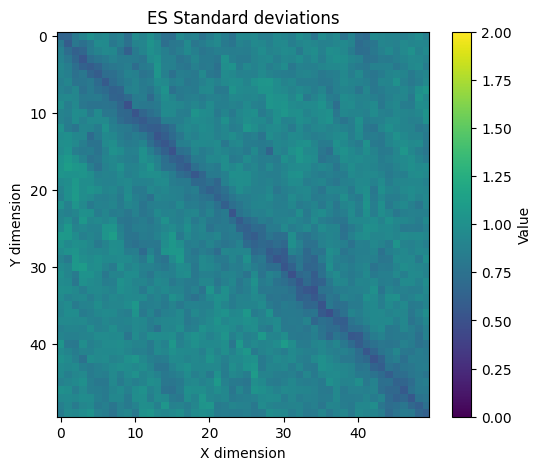

In [54]:
plot_field_from_vector(np.std(U_posterior_es, axis=0), px, py, 0, 2, title="ES Standard deviations")

# Ensemble information filter

In [55]:
# Create EnIF object
gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps)

In [56]:
# Fit both precision and sparse linear map H
gtmap.fit(U, Y, learning_algorithm="influence-boost", ordering_method="metis", verbose_level=5)
prior_prec_est = gtmap.Prec_u.copy()

max degree of graph is: 4
Permutation optimization took 0.008441925048828125 seconds


/Users/BERL/Github/venv_sksparse/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Parameters in precision: 7400
Parameters in Cholesky factor: 36436
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1373.91it/s]


Precision has log-determinant: 2267.48999229266
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.00it/s]

Total elements: 125000
Non-zero elements: 50
Fraction of non-zeros: 0.0004
Calculating unexplained variance


In [57]:
U_posterior = gtmap.transport(U, Y, d, verbose_level=5)

Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 50)
Total residual variance: 50.528969463096956
Unexplained variance: 0.5289694630969478
Measurement variance: 50.0
Mapping canonical-scaled realizations to moment realization


# Adaptive localization

In [58]:
# Covariance matches the noise added to observations above
covariance = np.linalg.inv(Prec_eps.A) # np.ones(num_observations)  # N(0, 1) covariance

adaptive_smoother = AdaptiveESMDA(
    covariance=covariance,
    observations=d,
    seed=1,
)

In [59]:
X = np.copy(U).T

D = adaptive_smoother.perturb_observations(
    ensemble_size=n, alpha=1.0
)

U_adaptive_posterior = adaptive_smoother.assimilate(
        X=X, Y=Y.T, D=D, alpha=1.0, #correlation_threshold=0.9
    ).T

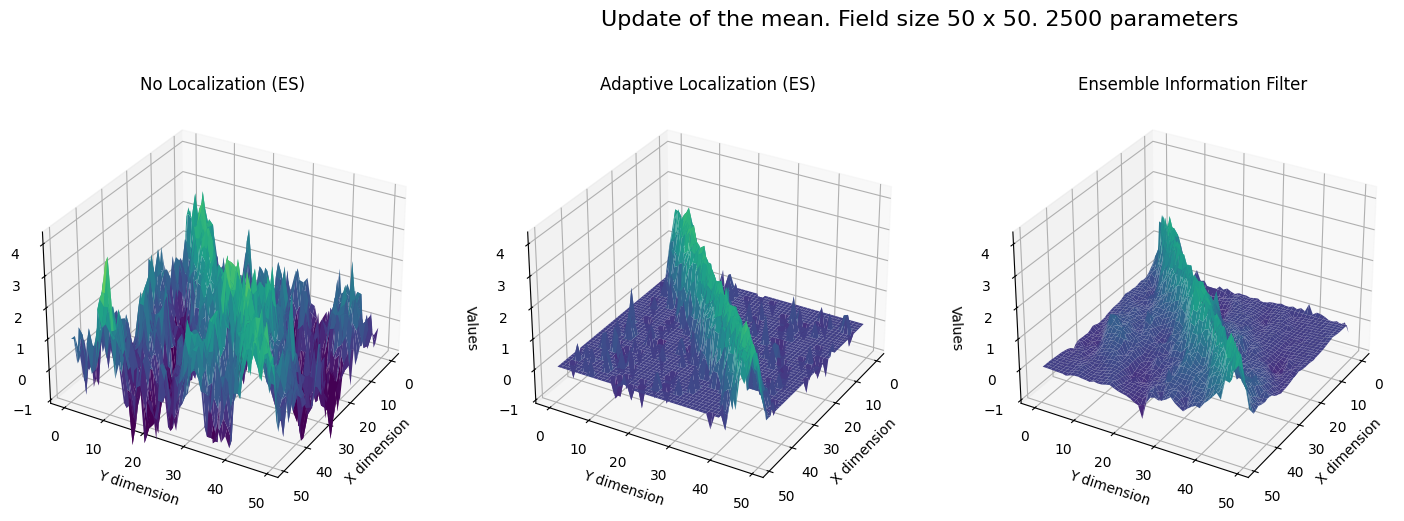

In [60]:
plot_fields_3d(
    [np.mean(U_posterior_es-U, axis=0), 
     np.mean(U_adaptive_posterior-U, axis=0),
     np.mean(U_posterior-U, axis=0),
    ], 
    px, py, 
    vmin=-1, vmax=vmax, 
    titles=['No Localization (ES)', 'Adaptive Localization (ES)', 'Ensemble Information Filter'], 
    overall_title=f"Update of the mean. Field size {px} x {py}. {px*py} parameters",
    file_name = f"update_mean_size_{px}x{py}"
)

## GraphSPME - Scaling the ensemble U before and after

In [61]:
import graphspme as gspme

In [62]:
Z = nx.to_scipy_sparse_array(Graph_u)
Z.data[:]=1
Z = Z.tolil()
Z.setdiag(1)
Z = Z.tocsc()

In [63]:
Z= sp.sparse.csc_matrix(Z)

In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
scaler_u = StandardScaler()
U_scaled = scaler_u.fit_transform(U)

In [66]:
import time
start = time.time()
prec_gspme_scaled = gspme.prec_sparse(
    U_scaled,
    Z,
    markov_order=3,
    cov_shrinkage=True,
    symmetrization=True,
    shrinkage_target=2,
    inflation_factor=1.5,
)
stop = time.time()
print(f"Time since taken: {(stop-start)/60}")

Time since taken: 0.0012719353040059407


In [67]:
gtmap_scale = EnIF(Prec_u = prec_gspme_scaled, Prec_eps=Prec_eps)
gtmap_scale.fit(U_scaled, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
U_posterior_scaled = gtmap_scale.transport(U_scaled, Y, d, verbose_level=5, iterative=True)

Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.96it/s]


Total elements: 125000
Non-zero elements: 50
Fraction of non-zeros: 0.0004
Calculating unexplained variance
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 50)
Total residual variance: 50.528969463096956
Unexplained variance: 0.5289694630969478
Measurement variance: 50.0
Mapping canonical-scaled realizations to moment realization


Mapping data to moment parametrisation realization-by-realization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 238.82it/s]


### This plot goes into the paper

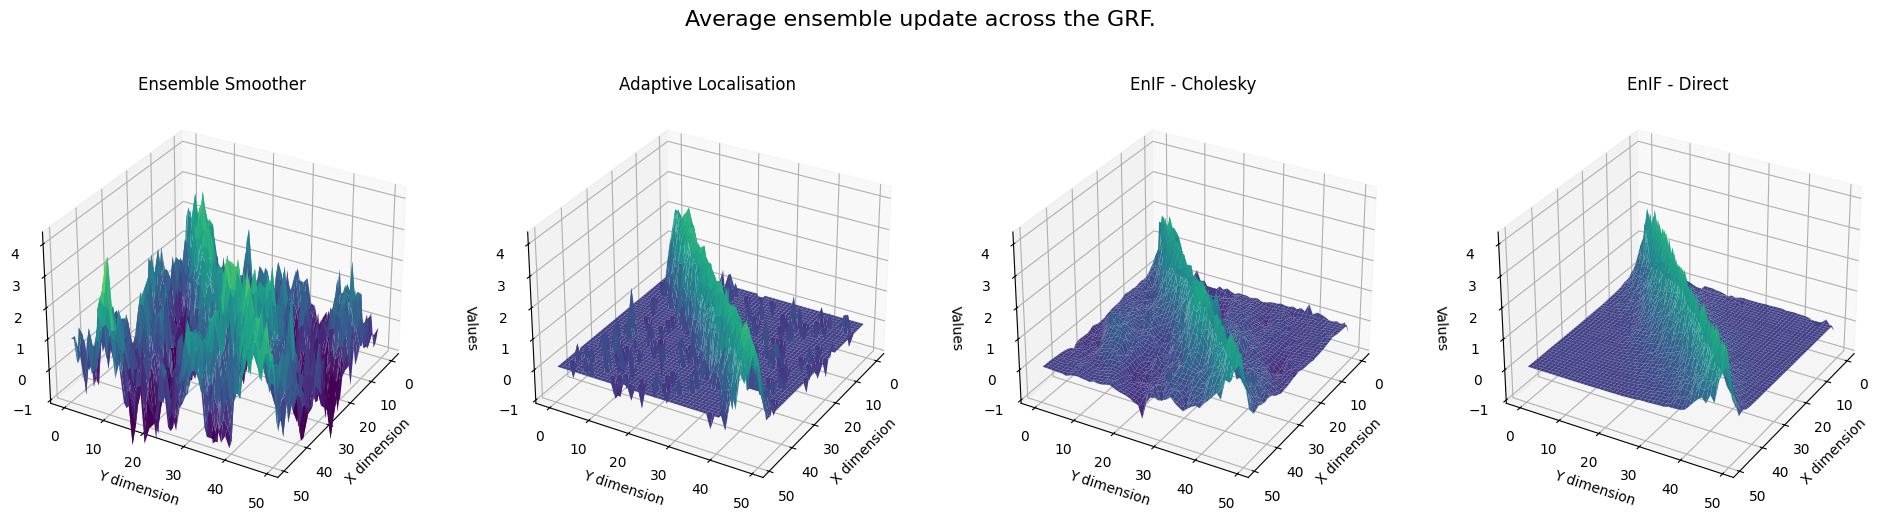

In [68]:
U_posterior_unscaled = scaler_u.inverse_transform(U_posterior_scaled)
plot_fields_3d(
    [np.mean(U_posterior_es-U, axis=0), 
     np.mean(U_adaptive_posterior-U, axis=0),
     np.mean(U_posterior-U, axis=0),
    np.mean(U_posterior_unscaled-U, axis=0),
    ],
    px, py, 
    vmin=-1, vmax=vmax, 
    titles=['Ensemble Smoother', 'Adaptive Localisation', 'EnIF - Cholesky', "EnIF - Direct"], 
    overall_title=f"Average ensemble update across the GRF.",
    #horizontal_title=f"{px} x {py}",
    file_name = f"update_mean_size_{px}x{py}"
)

## Difference between influence boost and LASSO regression

In [69]:
gtmap_lasso = EnIF(Prec_u = prec_gspme_scaled, Prec_eps=Prec_eps)
gtmap_lasso.fit(U_scaled, Y, learning_algorithm="LASSO", ordering_method="best", verbose_level=5)

Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]

Total elements: 125000
Non-zero elements: 1255
Fraction of non-zeros: 0.01004
Calculating unexplained variance


In [70]:
print(gtmap.H)

  (0, 0)	0.9633396455177335
  (1, 51)	0.9952345653534765
  (2, 102)	0.9770893453906987
  (3, 153)	0.9418437022126833
  (4, 204)	0.9590155449798082
  (5, 255)	0.9739552338788467
  (6, 306)	0.9663068652170896
  (7, 357)	0.9717837810871187
  (8, 408)	0.9758365633807274
  (9, 459)	0.9834483392951645
  (10, 510)	0.9617047588092028
  (11, 561)	1.0080599458808421
  (12, 612)	0.9544078008824771
  (13, 663)	0.988394076086253
  (14, 714)	0.9608237422323685
  (15, 765)	0.9622682543195413
  (16, 816)	0.9719388124541914
  (17, 867)	0.9528839295415911
  (18, 918)	0.9782111250169196
  (19, 969)	0.9611975106759454
  (20, 1020)	0.9662667469696401
  (21, 1071)	0.9964879092779436
  (22, 1122)	0.9910546191699243
  (23, 1173)	0.9935366770516975
  (24, 1224)	0.9819569849467116
  (25, 1275)	0.9571066780736088
  (26, 1326)	0.9542451428096315
  (27, 1377)	0.9735129020355566
  (28, 1428)	0.9457217814234398
  (29, 1479)	0.9778761772171997
  (30, 1530)	0.9661548917568222
  (31, 1581)	0.9743945011120728
  (32, 163

In [71]:
print(gtmap_lasso.H)

  (0, 0)	0.8886580434610775
  (32, 2)	-0.010064955048252267
  (40, 3)	0.008226174410037847
  (47, 3)	0.011779293943266768
  (9, 6)	0.0009213036140454548
  (9, 7)	0.009876498944672841
  (15, 7)	0.0004899179009553198
  (27, 7)	0.004271535437273841
  (8, 8)	-0.0011855832760798682
  (9, 8)	3.365949494028558e-05
  (46, 8)	-0.0006718730860857603
  (5, 11)	-0.003257348717177919
  (7, 12)	-0.00432193216332034
  (27, 14)	-0.008402378351652381
  (46, 20)	-0.0012501573874505248
  (26, 23)	0.00513893553296126
  (8, 25)	-0.003521227673586388
  (27, 26)	0.0018516279134882544
  (20, 28)	0.018307780302510963
  (15, 29)	-0.0013680971306232967
  (47, 29)	-0.011203229433838445
  (26, 33)	0.004024401128093613
  (32, 34)	-0.011325691954135167
  (27, 35)	0.00018758645410131133
  (47, 35)	0.007854598246412084
  :	:
  (46, 2471)	0.002403334391330035
  (47, 2471)	-0.013058216263661264
  (46, 2472)	0.00082054147797375
  (46, 2473)	0.0035280948481571147
  (27, 2474)	-0.009531417034462995
  (20, 2475)	-0.00164675

In [75]:
print(gtmap.H.nnz)
print(gtmap_lasso.H.nnz)
px * px * py

50
1255


125000

## Multiplot for paper

In [ ]:
if px == 10:
    print(px)
    updates_10 = [
        np.mean(U_posterior_es-U, axis=0), 
        np.mean(U_adaptive_posterior-U, axis=0),
        np.mean(U_posterior-U, axis=0),
        np.mean(U_posterior_unscaled-U, axis=0),
    ]
elif px == 50:
    print(px)
    updates_50 = [
        np.mean(U_posterior_es-U, axis=0), 
        np.mean(U_adaptive_posterior-U, axis=0),
        np.mean(U_posterior-U, axis=0),
        np.mean(U_posterior_unscaled-U, axis=0),
    ]
elif px == 200:
    print(px)
    updates_200 = [
        np.mean(U_posterior_es-U, axis=0), 
        np.mean(U_adaptive_posterior-U, axis=0),
        np.mean(U_posterior-U, axis=0),
        np.mean(U_posterior_unscaled-U, axis=0),
    ]

In [436]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_fields_3d_rows(inputs, px_values, py_values, vmin, vmax, titles, 
                        overall_title="Overall 3D Fields", 
                        file_name=None):
    """
    Plots 3D fields for multiple sizes (px, py) in rows, with row labels for px x py.

    Parameters:
    - inputs: List of lists, each containing flattened 2D fields for a specific size.
              Example: [inputs_10, inputs_50, inputs_200].
    - px_values: List of px (x-dimensions) for each row.
    - py_values: List of py (y-dimensions) for each row.
    - vmin: Minimum value for colormap and z-axis.
    - vmax: Maximum value for colormap and z-axis.
    - titles: List of titles for each column (shared across all rows).
    - overall_title: The overall title for the figure.
    - file_name: Filename to save the figure.
    """
    num_rows = len(inputs)
    num_cols = len(titles)
    
    fig = plt.figure(figsize=(24, 6 * num_rows))  # Adjust figure size for rows
    
    # Main title at the top
    fig.suptitle(overall_title, fontsize=26, y=1.01)

    # Add column titles above the first row
    for col_idx, title in enumerate(titles):
        x_pos = 0.2 + 0.8 * col_idx / num_cols
        fig.text(x_pos, 0.925, title, va='center', ha='center', fontsize=20)

    # Plot rows and row titles
    for row_idx, (row_inputs, px, py) in enumerate(zip(inputs, px_values, py_values)):
        # Add row title (px x py) on the left
        y_pos = 0.77 - row_idx * 0.8 / num_rows
        fig.text(0.055, y_pos, f"{px} x {py}", va='center', ha='center', 
                 rotation='vertical', fontsize=20)
        
        for col_idx, U_i in enumerate(row_inputs):
            field_2d = U_i.reshape((px, py))
            x = np.linspace(0, px-1, px)
            y = np.linspace(0, py-1, py)
            X, Y = np.meshgrid(x, y)

            ax = fig.add_subplot(num_rows, num_cols, row_idx * num_cols + col_idx + 1, 
                                 projection='3d')
            surf = ax.plot_surface(X, Y, field_2d.T, cmap='viridis', edgecolor='none', 
                                   vmin=vmin, vmax=vmax)
            ax.set_xlabel('X dimension')
            ax.set_ylabel('Y dimension')
            ax.set_zlabel('Values')
            ax.set_zlim(vmin, vmax)
            ax.view_init(azim=30)

    # Save the plot if a filename is specified
    if file_name is not None:
        plt.savefig(f"{file_name}.pdf", format='pdf', bbox_inches='tight')

    plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.92])  # Adjust plot layout within figure
    plt.show()


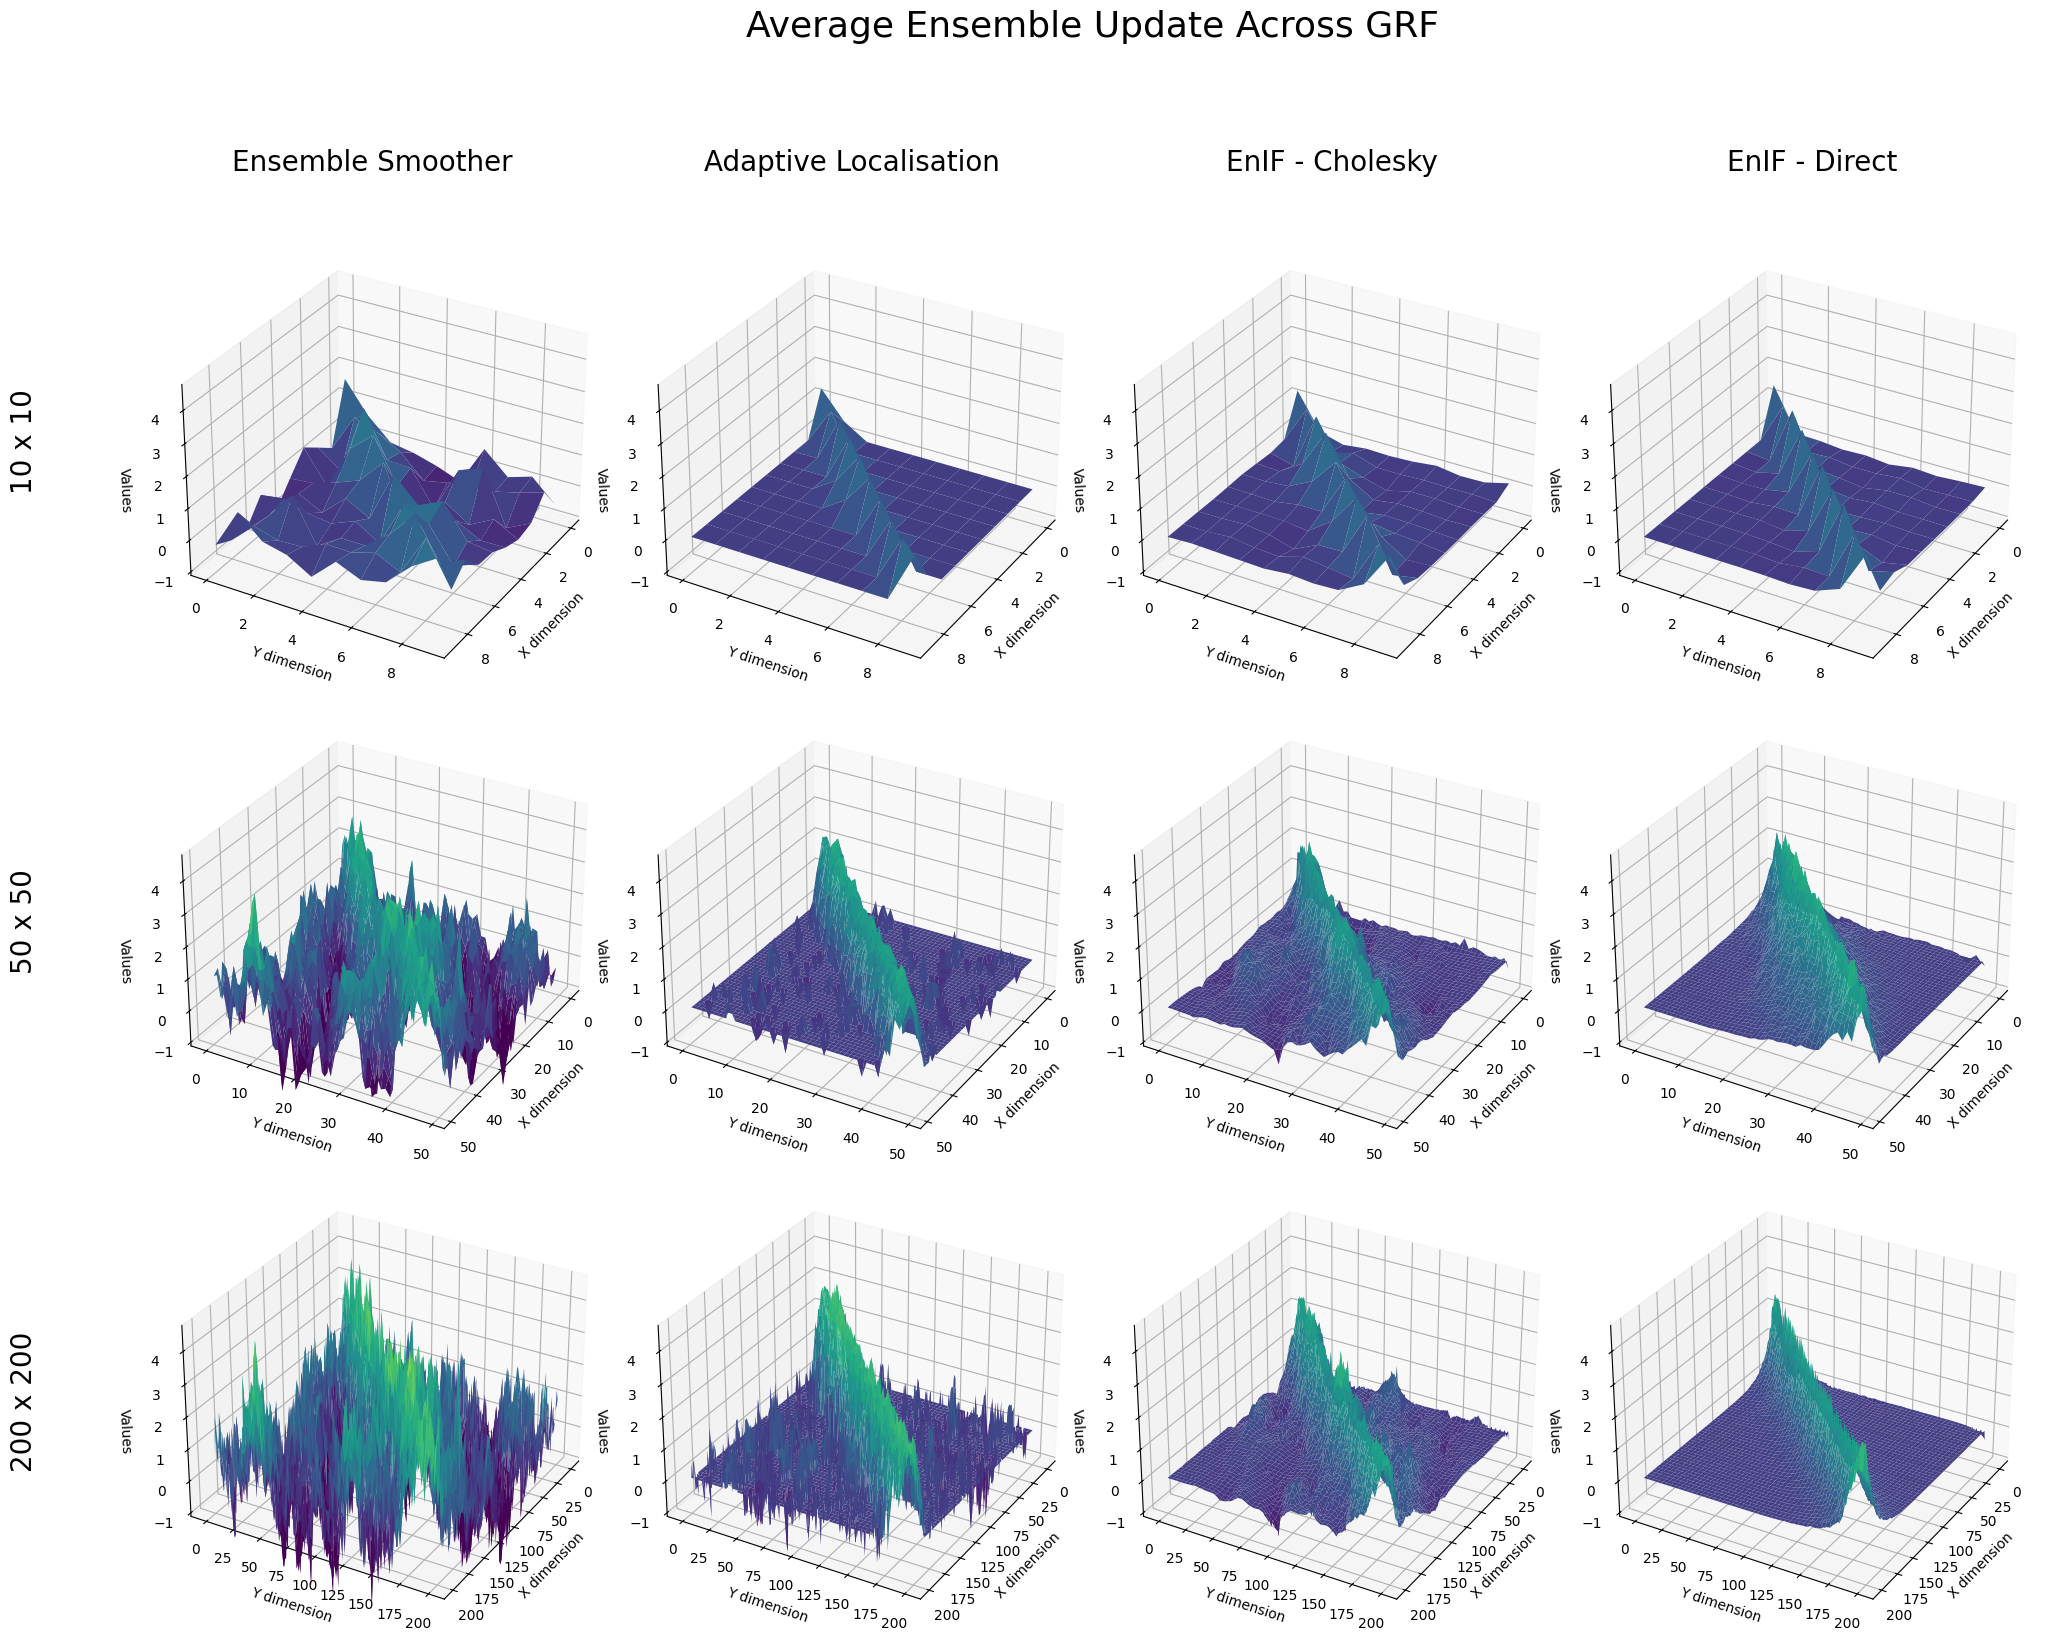

In [437]:
px_values = [10, 50, 200]
py_values = [10, 50, 200]
titles = ['Ensemble Smoother', 'Adaptive Localisation', 'EnIF - Cholesky', "EnIF - Direct"]

plot_fields_3d_rows(
    inputs=[updates_10, updates_50, updates_200], 
    px_values=px_values, 
    py_values=py_values, 
    vmin=-1, vmax=vmax, 
    titles=titles, 
    overall_title="Average Ensemble Update Across GRF", 
    file_name="update_mean_grf"
)